<a href="https://colab.research.google.com/github/dmamur/elembert/blob/main/notebooks/tests/elembert_classification_kfolds_permutation_dim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pickle,random
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding,Dense,Dropout,Input,Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import re, glob,os,sys
from collections import defaultdict
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

def bert_module(query, key, value, i, config):
    # Multi headed self-attention
    attention_output = layers.MultiHeadAttention(
        num_heads=config.NUM_HEAD,
        key_dim=config.EMBED_DIM // config.NUM_HEAD,
        name="encoder_{}/multiheadattention".format(i),
        kernel_initializer=tf.keras.initializers.GlorotUniform(seed=config.seed)
    )(query, key, value)
    attention_output = layers.Dropout(0.1, name="encoder_{}/att_dropout".format(i))(
        attention_output
    )
    attention_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}/att_layernormalization".format(i)
    )(query + attention_output)

    # Feed-forward layer
    ffn = tf.keras.Sequential(
        [
            layers.Dense(config.FF_DIM, activation="relu",kernel_initializer=tf.keras.initializers.GlorotUniform(seed=config.seed)),
            layers.Dense(config.EMBED_DIM,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=config.seed)),
        ],
        name="encoder_{}/ffn".format(i),
    )
    ffn_output = ffn(attention_output)
    ffn_output = layers.Dropout(0.1, name="encoder_{}/ffn_dropout".format(i))(
        ffn_output
    )
    sequence_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}/ffn_layernormalization".format(i)
    )(attention_output + ffn_output)
    return sequence_output


def get_pos_encoding_matrix(max_len, d_emb):
    pos_enc = np.array(
        [
            [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)]
            if pos != 0
            else np.zeros(d_emb)
            for pos in range(max_len)
        ]
    )
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])  # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])  # dim 2i+1
    return pos_enc

def create_elembert_model(inputs,config):
    word_embeddings = layers.Embedding(config.VOCAB_SIZE, config.EMBED_DIM, mask_zero=True,name="element_embdgs",
                                       embeddings_initializer=tf.keras.initializers.GlorotUniform(seed=config.seed))(inputs)
    position_embeddings = layers.Embedding(input_dim=config.MAX_LEN,output_dim=config.EMBED_DIM,
                                           weights=[get_pos_encoding_matrix(config.MAX_LEN, config.EMBED_DIM)],
                                           #embeddings_initializer=tf.keras.initializers.GlorotUniform(seed=config.seed),
                                           name="position_embedding",)(tf.range(start=0, limit=config.MAX_LEN, delta=1))
    embeddings = word_embeddings + position_embeddings
    encoder_output = embeddings
    for i in range(config.NUM_LAYERS):
        encoder_output = bert_module(encoder_output, encoder_output, encoder_output, i, config)
    mlm_model = Model(inputs, encoder_output, name="masked_bert_model")

    return mlm_model


In [2]:
!git clone https://github.com/dmamur/elementsem.git

fatal: destination path 'elementsem' already exists and is not an empty directory.


In [3]:
class Config:
    MAX_LEN = 256
    BATCH_SIZE = 32
    LR = 0.001
    VOCAB_SIZE = 128
    EMBED_DIM = 32
    NUM_HEAD = 2 # used in bert model
    FF_DIM = 32 # used in bert model
    NUM_LAYERS = 2
    MNAME = 'elembert_'
    MVER = 'V1'
    DSPATH="/content/elementsem/data/"
    PREPATH="/content/elementsem/models/pretrained/"
    PATH="/content/elementsem/models/"
config = Config()
seed=12345
tf.random.set_seed(seed)
np.random.seed(seed)

In [4]:
#'sider_1','sider_2','sider_3','sider_4','sider_5', 'sider_6','sider_7', 'sider_8', 'sider_9', 'sider_10', 'sider_11', 'sider_12',
#'sider_13', 'sider_14', 'sider_15','sider_16','sider_17','sider_18','sider_19','sider_20','sider_21','sider_22','sider_23',
#'sider_24','sider_25','sider_26','sider_27','dimensionality','spacegroup','liquid_amorphous','BBBP','bace','clintox','nr-ahr',
#'nr-ar','sr-atad5','nr-er-lbd','sr-p53','nr-ar-lbd','nr-ppar-gamma','sr-hse','nr-er','sr-mmp','nr-aromatase','sr-are','HIV'
ds = 'dimensionality'
mname=config.PATH+config.MNAME+ds+'_%s_E_%s_H_%s_L_%s' % (config.MVER,config.EMBED_DIM,config.NUM_HEAD,config.NUM_LAYERS)

# Load vocabulary and types

In [5]:
if (ds=='HIV'):
  df = pd.read_csv(config.DSPATH+ds+config.MVER+'_ds.csv')
else:
  df = pd.read_csv(config.DSPATH+ds+'_ds.csv')

types = df['types'+config.MVER].apply(eval).apply(list)
labels  = to_categorical(np.asarray(df['labels']))
uniquelbls=len(np.unique(np.asarray(df['labels'])))

with open(config.PREPATH+'/el2id'+config.MVER+'.pkl', 'rb') as f:
    db = pickle.load(f)

element2id = db['el2id']
el2id = db['el2id']
config.VOCAB_SIZE = len(element2id)
print('vocabSize: ', config.VOCAB_SIZE)


vocabSize:  565


In [6]:
lens = [len(i) for i in types]
np.max(lens)

920

# Convert types to integers

In [7]:
#[random.shuffle(types[i]) for i in range(len(types))]
types0=[['[CLS]']+i+['[SEP]'] for i in types]
typesNumerical=[]
for i in types0:
    typesNumerical.append([element2id[j] for j in i])

x3 = tf.keras.preprocessing.sequence.pad_sequences(typesNumerical,dtype='int32',padding= 'post',truncating='post',maxlen=config.MAX_LEN)

#z = load_model(config.PREPATH+'/elembert_%s_E_%s_H_%s_L_%s.h5' % (config.MVER,config.EMBED_DIM,config.NUM_HEAD,config.NUM_LAYERS),compile=False)
#z.trainable = True

inputC = Input((config.MAX_LEN), dtype=tf.int32,name='types')


In [8]:
def scheduler(epoch):
    initial_lrate = config.LR
    drop = 0.92
    epochs_drop = 10
    lr = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    if lr<0.0001:
        lr = 0.0001
    return lr


epochs=2*config.BATCH_SIZE

print('dataLen: ',x3.shape,labels.shape)

dataLen:  (2194, 256) (2194, 3)


In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

# Assuming you have loaded your data into x3 and labels variables

# Define the number of folds
num_folds = 2

# Initialize Stratified K-Fold Cross-Validator
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize lists to store results
all_histories = []
all_reports = []
randseed = np.asarray([38005, 26930, 57873, 37766, 62593])
m = tf.keras.metrics.AUC()
score=np.zeros(num_folds)
# Iterate over folds
for fold, (train_idx, val_idx) in enumerate(kfold.split(x3, np.argmax(labels, axis=1))):
    print(f"\nTraining on Fold {fold + 1}...")
    config.seed = randseed[fold]
    z = create_elembert_model(inputC,config)
    e = Lambda(lambda x: x[:,0],name='clsTokenEmb')(z.output)
    f = Dense(uniquelbls, activation="softmax",name='out_tox',kernel_initializer=tf.keras.initializers.GlorotUniform(config.seed))(e)
    # Create and compile the model (assuming create_elembert_model function is available)
    model = Model(inputs=z.input, outputs=f)

    optimizer = tf.keras.optimizers.Adam(learning_rate=config.LR)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC()])

    # Extract training and validation sets
    x_train, x_val = x3[train_idx], x3[val_idx]
    y_train, y_val = labels[train_idx], labels[val_idx]

    # Train the model
    history = model.fit(
        x=x_train,
        y=y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        batch_size=config.BATCH_SIZE,
        verbose=0,
        callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)
    )

    # Evaluate the model on the validation set
    val_predictions = model.predict(x_val, batch_size=config.BATCH_SIZE)
    val_report = classification_report(np.argmax(y_val, axis=1), np.argmax(val_predictions, axis=1), output_dict=True)
    m.update_state(y_val, val_predictions)
    score[fold]=m.result().numpy()

    # Append results to lists
    all_histories.append(history)
    all_reports.append(val_report)
    print('ROC-AUC:', score[fold])

# Print the average classification report across folds
#avg_report = pd.DataFrame(all_reports).mean().to_dict()
print("\nAverage ROC-AUC:")
print(np.mean(score),'±',np.std(score))



Training on Fold 1...
35/35 [==============================] - 0s 5ms/step
ROC-AUC: 0.9602941870689392

Training on Fold 2...
35/35 [==============================] - 0s 5ms/step
ROC-AUC: 0.9541555643081665

Average ROC-AUC:
0.9572248756885529 ± 0.0030693113803863525


In [10]:
pd.DataFrame(val_report)

,0,1,2,accuracy,macro avg,weighted avg
precision,0.784768,0.964444,0.738596,0.79763,0.829270,0.827117
recall,0.769481,0.591281,0.997630,0.79763,0.786131,0.797630
f1-score,0.777049,0.733108,0.848790,0.79763,0.786316,0.789947
support,308.000000,367.000000,422.000000,0.79763,1097.000000,1097.000000


In [11]:
types1 = df['types'+config.MVER].apply(eval).apply(list)
[random.shuffle(types1[i]) for i in range(len(types1))]
types2=[['[CLS]']+i+['[SEP]'] for i in types1]
typesNumerical=[]
for i in types2:
    typesNumerical.append([element2id[j] for j in i])

x30 = tf.keras.preprocessing.sequence.pad_sequences(typesNumerical,dtype='int32',padding= 'post',truncating='post',maxlen=config.MAX_LEN)

x_train, x_val = x30[train_idx], x30[val_idx]
y_train, y_val = labels[train_idx], labels[val_idx]

val_predictions1 = model.predict(x_val, batch_size=config.BATCH_SIZE)
m.update_state(y_val, val_predictions1)
print('ROC-AUC:',m.result().numpy())
pd.DataFrame(classification_report(np.argmax(y_val, axis=1), np.argmax(val_predictions1, axis=1), output_dict=True))

35/35 [==============================] - 0s 5ms/step
ROC-AUC: 0.93258333


,0,1,2,accuracy,macro avg,weighted avg
precision,0.785479,0.973094,0.737303,0.798541,0.831959,0.829713
recall,0.772727,0.591281,0.997630,0.798541,0.787213,0.798541
f1-score,0.779051,0.735593,0.847936,0.798541,0.787527,0.791011
support,308.000000,367.000000,422.000000,0.798541,1097.000000,1097.000000


# Save results

In [12]:
extractorEmb = Model(inputs=model.inputs,outputs=model.get_layer(name="clsTokenEmb").output)

preds = model.predict(x3,batch_size = config.BATCH_SIZE)

dbresults={}
dbresults['pred_emb'] = extractorEmb.predict(x3,batch_size = config.BATCH_SIZE)
dbresults['pred_cls'] = preds
dbresults['y_cls'] = labels
dbresults['formula'] = df['formula']
dbresults['ids'] = df['ids']
dbresults['types'] = types
dbresults['trainidx'] = train_idx
dbresults['testidx'] = val_idx
dbresults['validx'] = val_idx

with open(mname+'_results.pkl', 'wb') as f:
    pickle.dump(dbresults, f)

69/69 [==============================] - 1s 5ms/step


# Postprocessing

In [13]:
from matplotlib import cm
from sklearn.manifold import TSNE
from sklearn import metrics
import seaborn as sns
tsne = TSNE(n_components=2, verbose=0, random_state=123)
z = tsne.fit_transform(dbresults['pred_emb'])

In [14]:
dfr = pd.DataFrame()
dfr["y"] = np.asarray(dbresults['y_cls'].argmax(axis=-1)).astype('bool')
dfr["yp"] = np.asarray(dbresults['pred_cls'].argmax(axis=-1)).astype('bool')
dfr["tSNE1"] = z[:,0]
dfr["tSNE2"] = z[:,1]

/content/elementsem/models/elembert_dimensionality_V1_E_32_H_2_L_2 binary tf-acc: 0.49134 AUC: 0.9455936


ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (2).

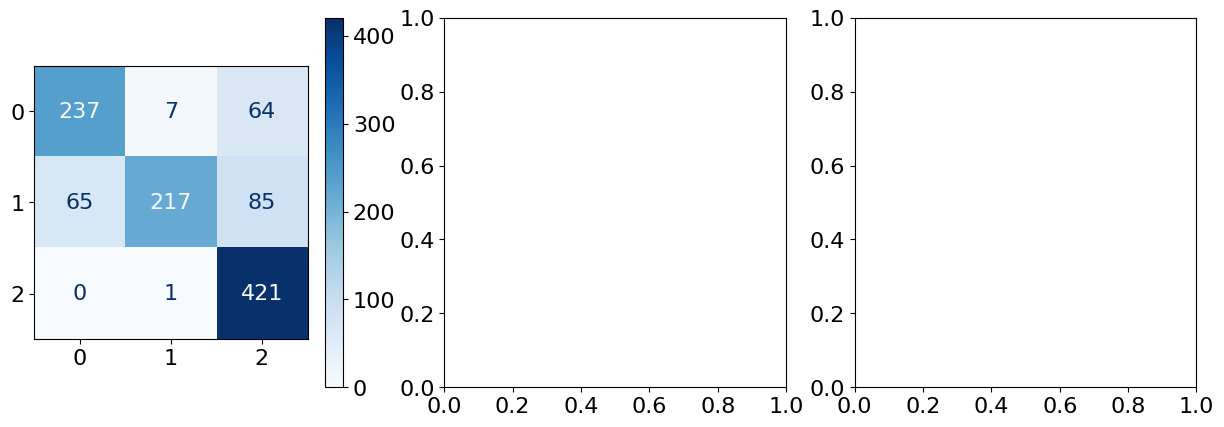

In [15]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(1, 3, figsize=(15, 4.8))
y_pclasses = dbresults['pred_cls'][dbresults['testidx']].argmax(axis=-1).tolist()
y_classes = dbresults['y_cls'][dbresults['testidx']].argmax(axis=-1)
m = tf.keras.metrics.AUC()
m.update_state(dbresults['y_cls'][dbresults['testidx']], dbresults['pred_cls'][dbresults['testidx']])
print(mname,'binary tf-acc:',tf.keras.metrics.binary_accuracy(y_classes, y_pclasses, threshold=0.5).numpy(),'AUC:',m.result().numpy())
confusion_matrix = metrics.confusion_matrix(y_classes, y_pclasses)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,
                                            display_labels=['False','True'])
cm_display.plot(ax=axes[0],cmap=plt.cm.Blues)

dfr=dfr.sort_values(by=['y'])
sns.scatterplot(ax=axes[1],x="tSNE1", y="tSNE2", hue=dfr.y.tolist(),data=dfr,alpha=0.4)#.set(title=title+" data T-SNE projection")
axes[1].set_xlabel('$tSNE_1$')
axes[1].set_ylabel('$tSNE_2$',labelpad=1)
axes[1].set_title('Reference')
dfr=dfr.sort_values(by=['yp'])
sns.scatterplot(ax=axes[2],x="tSNE1", y="tSNE2", hue=dfr.yp.tolist(),data=dfr,alpha=0.4)#.set(title=title+" data T-SNE projection")
axes[2].set_title('Predicted')
axes[2].set_xlabel('$tSNE_1$')
axes[2].set_ylabel('$tSNE_2$',labelpad=1)
axes[2].legend('',frameon=False)
fig.tight_layout()
plt.savefig(mname+'_tsne.png',format='png',dpi=800,bbox_inches = "tight")
plt.show()